In [25]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import solvers, matrix

In [26]:
Nx = 2
Ny = 3
Nu = 1
Np = 30
Nc = Np - 1
dt = 0.1
step = Nc
row = 1000
M = 10
kesi = np.zeros([Nx + Nu, 1])

In [5]:
xr = 30
vr = 0
xb = 20
vb = 20
xe = -40
ve = 20
x = np.array([[xb - xe], [vb - ve]])
u = 0

In [99]:
A = np.array([[1, dt], [0, 1]])
B = np.array([[0], [dt]])
A_ex = np.vstack([np.hstack([A, B]), 
                  np.hstack([np.zeros([Nu, Nx]), np.eye(Nu)])])
B_ex = np.vstack([B, 
                  np.eye(Nu)])
C_ex = np.eye(Ny)
PSI = np.zeros([Ny * Np, Nx + Nu])
THETA = np.zeros([Ny * Np, Nu * Nc])
for i in range(Np):
    PSI[i * Ny: (i + 1) * Ny, :] = C_ex.dot(np.linalg.matrix_power(A_ex, i + 1))
    for j in range(Nc):
        if j <= i:
            THETA[i * Ny: (i + 1) * Ny, j * Nu: (j + 1) * Nu] = C_ex.dot(np.linalg.matrix_power(A_ex, i - j)).dot(B_ex)
        else:
            THETA[i * Ny: (i + 1) * Ny, j * Nu: (j + 1) * Nu]= np.zeros([Ny, Nu])

In [100]:
lower = np.vstack([np.kron(np.ones([Nc, 1]), -20 * dt), 
                   np.zeros([1, 1])])
upper = np.vstack([np.kron(np.ones([Nc, 1]), 20 * dt), 
                   M * np.ones([1, 1])])
Ymin = np.kron(np.ones([Np, 1]), np.array([[10], [-50], [-10]]))
Ymax = np.kron(np.ones([Np, 1]), np.array([[100], [50], [10]]))
Q = np.kron(np.eye(Np), np.diag([10, 0, 1]))
R = np.eye(Nu * Nc)

     pcost       dcost       gap    pres   dres
 0: -1.4774e+05 -3.0477e+05  8e+05  1e+00  9e-16
 1: -1.0297e+05 -2.4370e+05  4e+05  5e-01  1e-15
 2: -7.5531e+04 -1.5906e+05  2e+05  2e-01  9e-16
 3: -5.4029e+04 -9.1955e+04  5e+04  3e-02  7e-16
 4: -5.1527e+04 -7.2433e+04  3e+04  1e-02  3e-16
 5: -4.9353e+04 -6.1260e+04  1e+04  4e-03  4e-16
 6: -4.9586e+04 -5.2266e+04  3e+03  8e-04  2e-16
 7: -4.9648e+04 -5.0569e+04  1e+03  3e-04  2e-16
 8: -4.9691e+04 -4.9809e+04  1e+02  2e-05  1e-16
 9: -4.9699e+04 -4.9709e+04  1e+01  7e-07  7e-17
10: -4.9700e+04 -4.9700e+04  2e-01  1e-08  1e-16
11: -4.9700e+04 -4.9700e+04  4e-03  1e-10  1e-16
Optimal solution found.


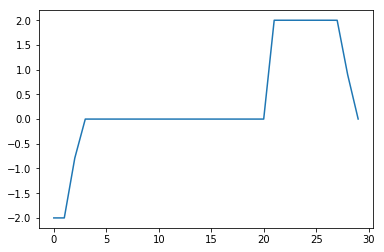

In [59]:
s = []
sc = 20
vc = -10
obs = [np.array([[xb], [vb]]) for _ in range(Np)]
ego = [np.array([[xe], [ve]]) for _ in range(Np)]
for i in range(1):
    kesi[:Nx] = x
    kesi[-Nu] = u
    A_cons = np.vstack([np.hstack([THETA, np.zeros([Ny * Np, 1])]), 
                        np.hstack([-THETA, np.zeros([Ny * Np, 1])]), 
                        np.eye(Nc + 1), 
                        -np.eye(Nc + 1)])
    b_cons = np.vstack([Ymax - PSI.dot(kesi), 
                        -Ymin + PSI.dot(kesi), 
                        upper, 
                        -lower])
    H = np.vstack([np.hstack([THETA.T.dot(Q).dot(THETA) + R, np.zeros([Nu * Nc, 1])]), 
                   np.hstack([np.zeros([1, Nu * Nc]), row * np.ones([1, 1])])])
    Yita_ref = np.kron(np.ones([Np, 1]), np.array([[xr], [vr], [0]]))
    E = PSI.dot(kesi) - Yita_ref
    f = np.hstack([2 * E.T.dot(Q).dot(THETA), np.zeros([1, 1])])

    P = matrix(H)
    q = matrix(f.T)
    G = matrix(A_cons)
    h = matrix(b_cons)
    sol = solvers.qp(P, q, G, h)
    control = np.array(sol['x'])
    plt.plot(control)
    state = PSI.dot(kesi) + THETA.dot(control[:Nc])
    state = np.hstack([kesi, state.reshape([Ny, Np])])
    
    for j in range(step - 1):
        ub = 0 * np.random.randn()
        ue = ub - state[2, j + 1]
        ue = np.clip(ue, -10, 10)
        obs[j + 1] = A.dot(obs[j]) + B.dot(ub)
        ego[j + 1] = A.dot(ego[j]) + B.dot(ue)
        obs[j + 1][1] = np.clip(obs[j + 1][1], 0, 40)
        ego[j + 1][1] = np.clip(ego[j + 1][1], 0, 40)
        
    s.append(np.vstack([np.concatenate(obs, 1), np.concatenate(ego, 1)]))
    x = obs[step] - ego[step]
    u = state[2, step]
    
    if x[0] <= sc & x[1] <= vc:
        print('distance close')
        break
    
    obs = [obs[step] for _ in range(Np)]
    ego = [ego[step] for _ in range(Np)]

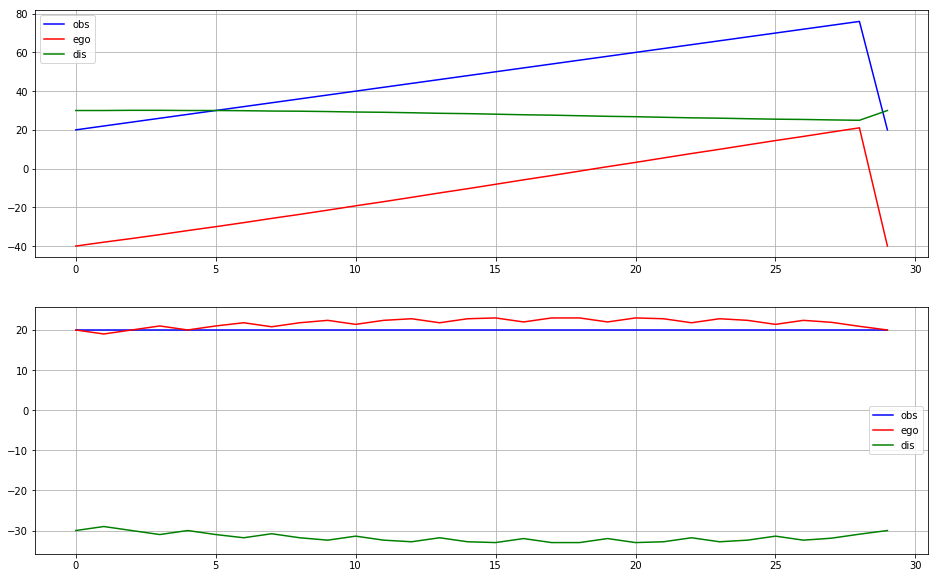

In [60]:
s = np.concatenate(s, 1)
plt.figure(figsize=[16, 10])
plt.subplot(211)
plt.grid()
plt.plot(s[0, :], 'b', label='obs')
plt.plot(s[2, :], 'r', label='ego')
plt.plot(s[0, :] - s[2, :] - xr, 'g', label='dis')
plt.legend()
plt.subplot(212)
plt.grid()
plt.plot(s[1, :], 'b', label='obs')
plt.plot(s[3, :], 'r', label='ego')
plt.plot(s[1, :] - s[3, :] - xr, 'g', label='dis')
plt.legend()